<a href="https://colab.research.google.com/github/Aman78695/time-series/blob/main/EDA_time_sreies_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Time Series Notes

In our day-to-day life, we encounter time-series related tasks more often than not. The most frequent questions asked are the following: what will happen with our metrics in the next day/week/month/etc., how many user will install our app, how much time will they spend online, how many actions will users complete, and so on. We can approach these prediction tasks using different methods depending on the required quality of the prediction, length of the forecast period, and, of course, the time within which we have to choose features and tune parameters to achieve desired results.

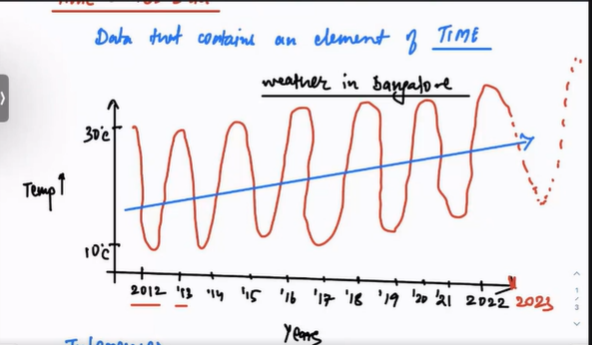

#**Components of time series data**

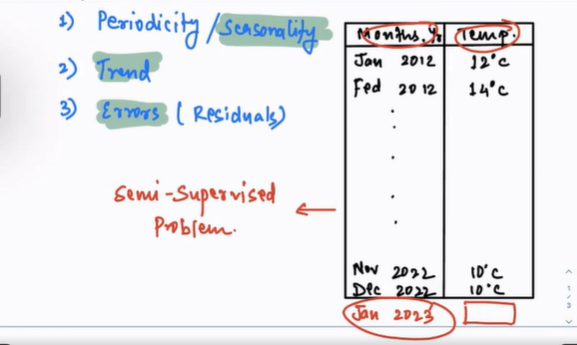

In [1]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                   # some useful functions
from tqdm import tqdm_notebook


In [30]:
ads = pd.read_csv('/content/ads.csv - ads.csv.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('/content/currency.csv - currency.csv.csv', index_col=['Time'], parse_dates=['Time'])

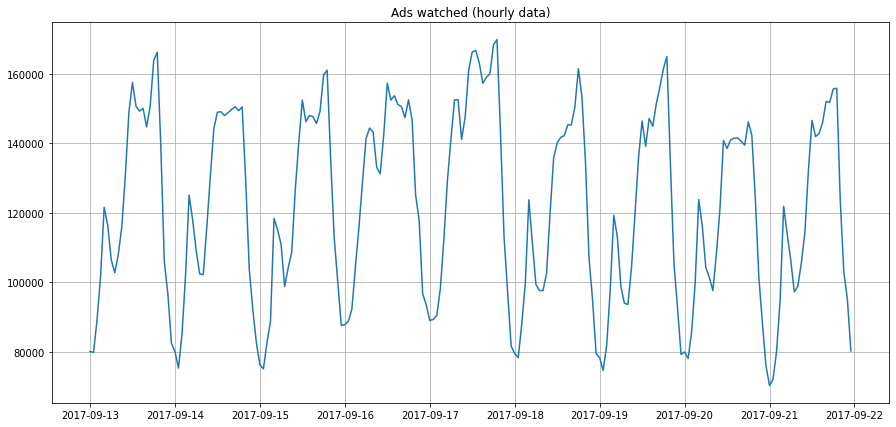

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

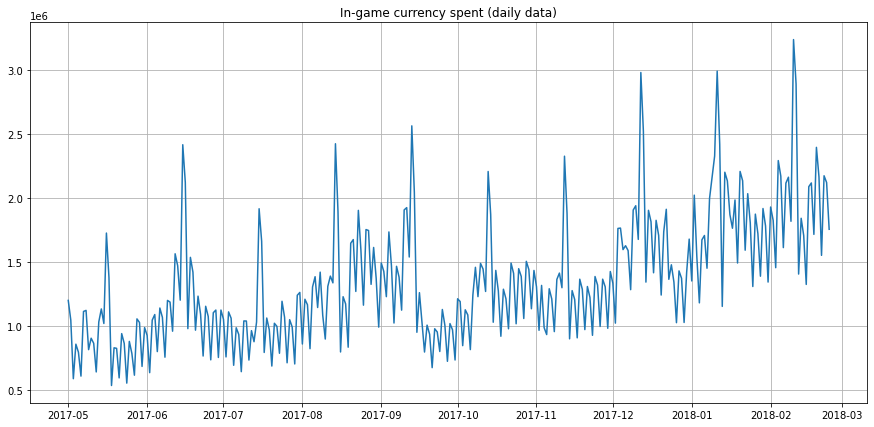

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

In [ ]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

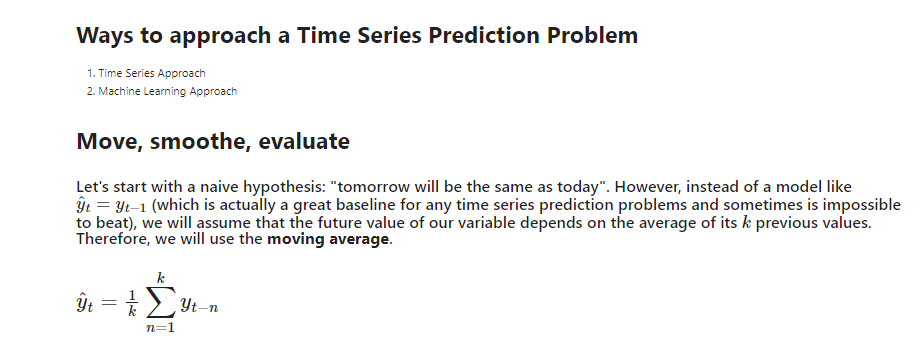

In [ ]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

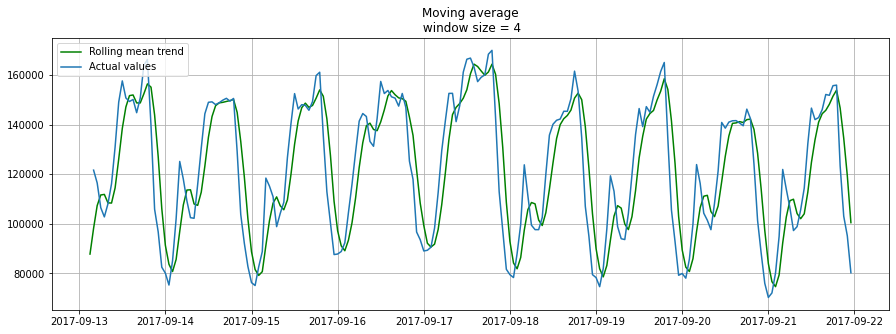

In [ ]:
plotMovingAverage(ads, 4) 

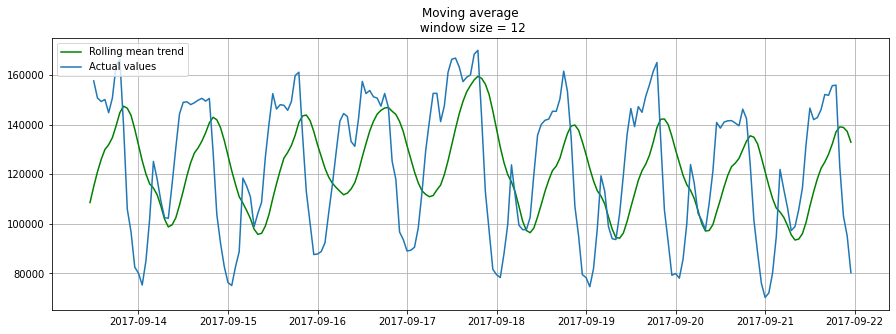

In [ ]:
plotMovingAverage(ads, 12) 

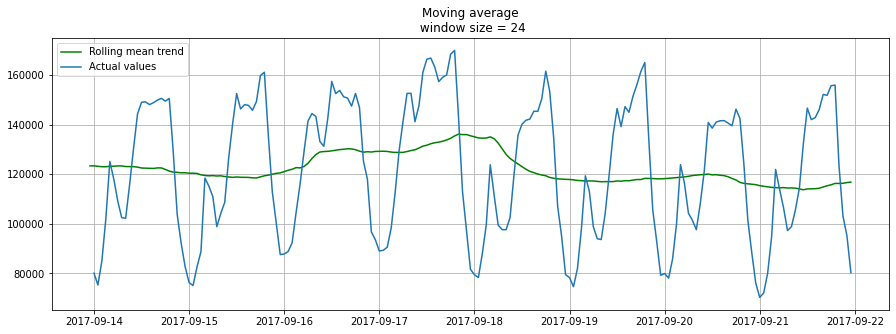

In [ ]:
plotMovingAverage(ads, 24)

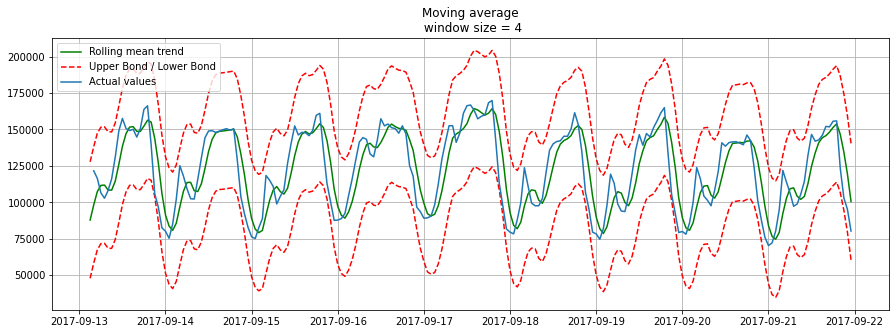

In [ ]:
plotMovingAverage(ads, 4, plot_intervals=True)

**When we applied daily smoothing on hourly data, we could clearly see the dynamics of ads watched. During the weekends, the values are higher (more time to play on the weekends) while fewer ads are watched on weekdays.**

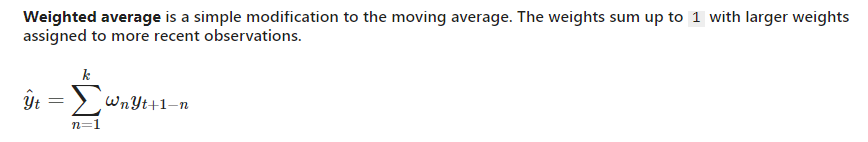

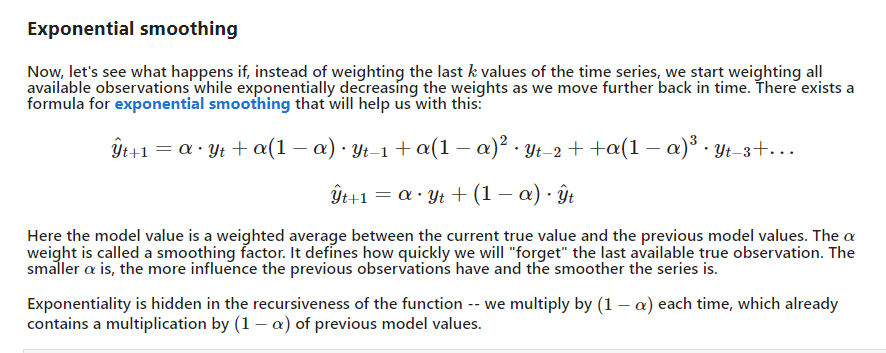

In [ ]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [ ]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

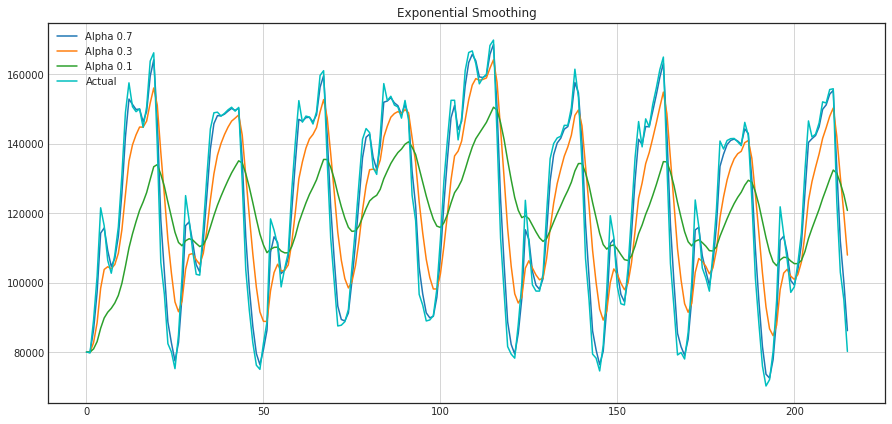

In [ ]:
plotExponentialSmoothing(ads.Ads, [0.7,0.3, 0.1])

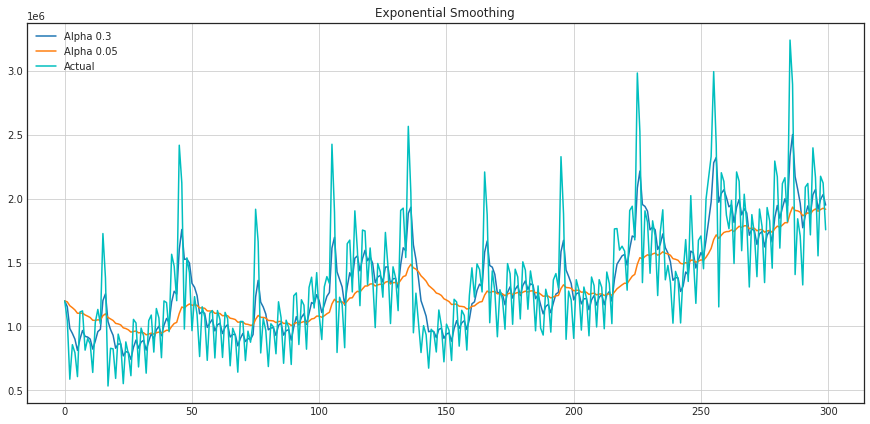

In [ ]:
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

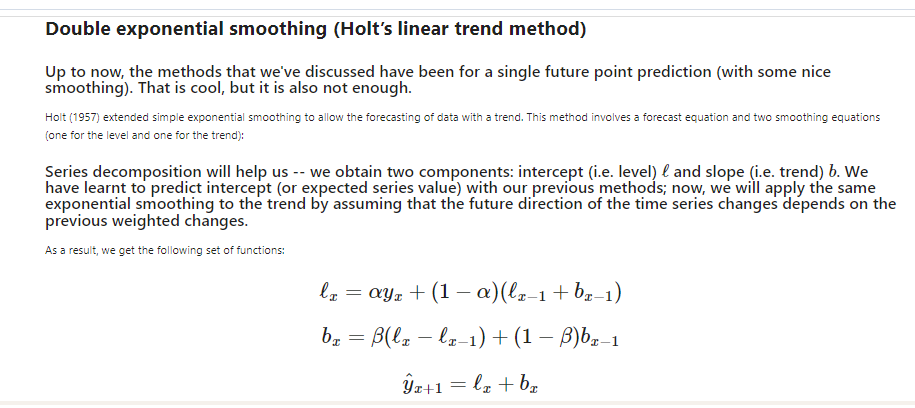

The first one describes the intercept, which, as before, depends on the current value of the series. The second term is now split into previous values of the level and of the trend. The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend. In this case, the 
 coefficient is a weight for exponential smoothing. The final prediction is the sum of the model values of the intercept and trend. 

In [ ]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

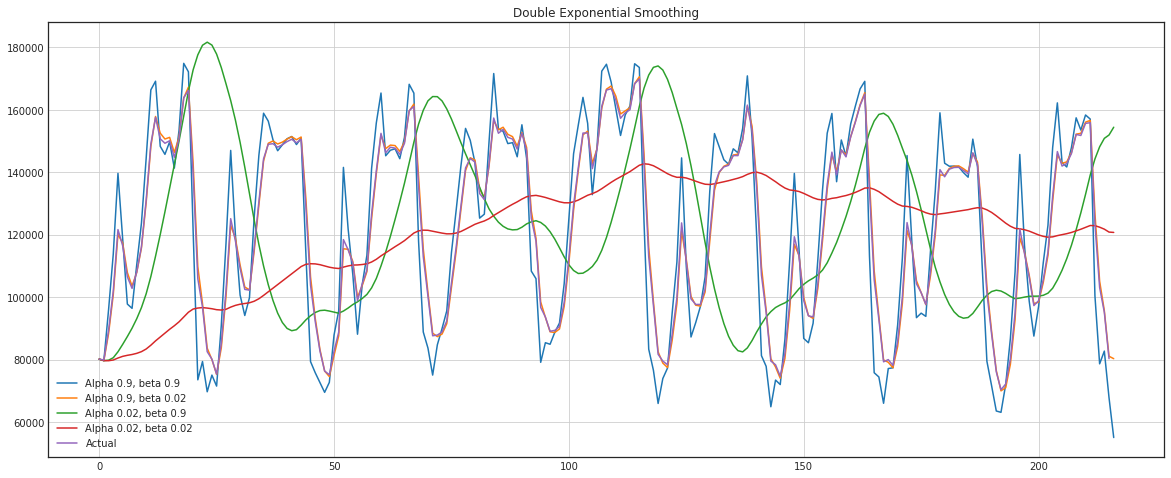

In [ ]:
plotDoubleExponentialSmoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])

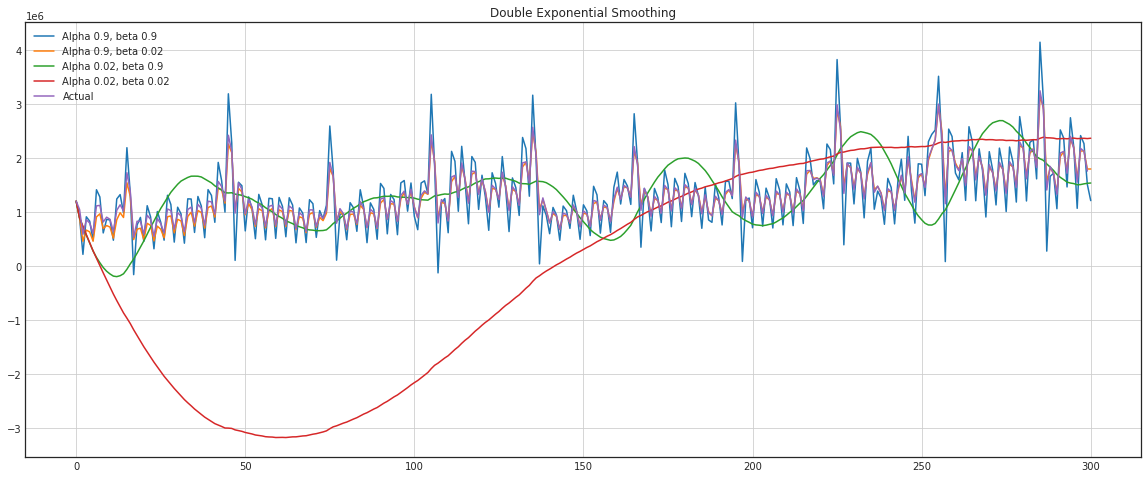

In [ ]:
plotDoubleExponentialSmoothing(currency.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])

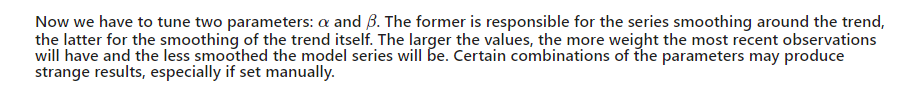

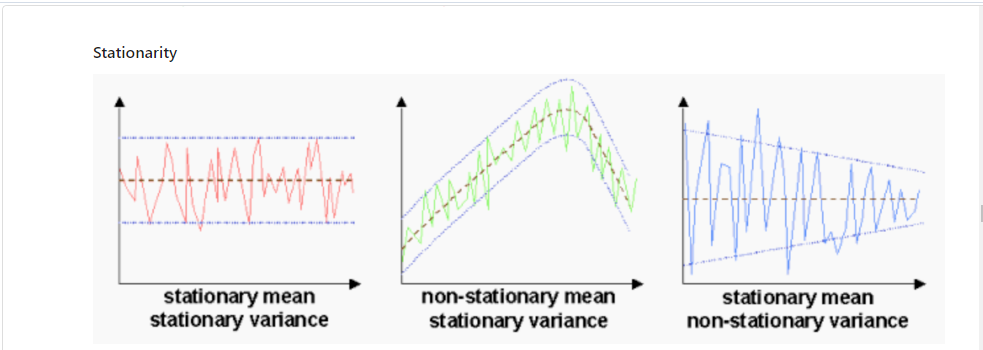

# So why is stationarity so important? Because it is easy to make predictions on a stationary series since we can assume that the future statistical properties will not be different from those currently observed. Most of the time-series models, in one way or the other, try to predict those properties (mean or variance, for example). Furture predictions would be wrong if the original series were not stationary. Unfortunately, most of the time series that we see outside of textbooks are non-stationary, but we can (and should) change this.
# So, in order to combat non-stationarity, we have to know our enemy, so to speak. Let's see how we can detect it. We will look at white noise and random walks to learn how to get from one to another for free. 

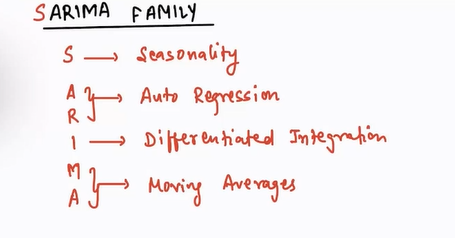

**When we use target variable to predict future target variable is called auto regression.**

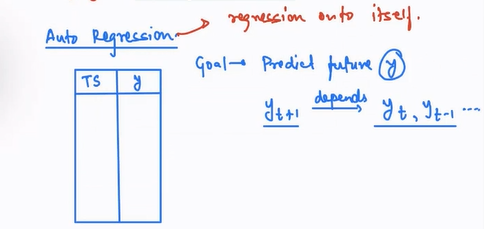

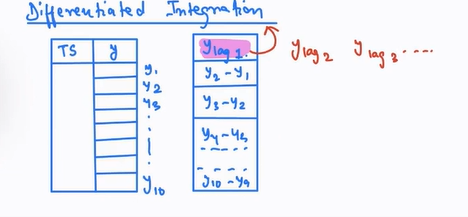

# **SARIMA Working**

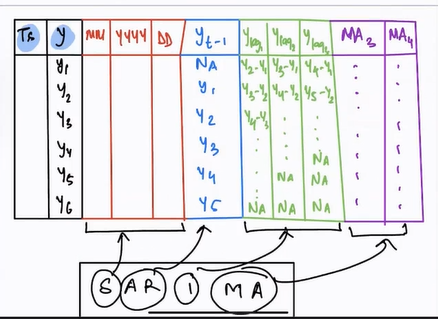

In [2]:
!pip install --upgrade pandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 82.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [3]:
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 6.9 MB/s eta 0:00:00
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [4]:
import pandas as pd


In [5]:
!pip install pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas_datareader as pdr

In [7]:
from datetime import datetime

In [8]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 114.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
  

In [9]:
import yfinance as yf

In [10]:
my_data = yf.download('TSLA')

[*********************100%***********************]  1 of 1 completed


In [11]:
my_data

Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-06-29    1.266667    1.666667    1.169333    1.592667    1.592667   
2010-06-30    1.719333    2.028000    1.553333    1.588667    1.588667   
2010-07-01    1.666667    1.728000    1.351333    1.464000    1.464000   
2010-07-02    1.533333    1.540000    1.247333    1.280000    1.280000   
2010-07-06    1.333333    1.333333    1.055333    1.074000    1.074000   
...                ...         ...         ...         ...         ...   
2023-02-27  202.029999  209.419998  201.259995  207.630005  207.630005   
2023-02-28  210.589996  211.229996  203.750000  205.710007  205.710007   
2023-03-01  206.210007  207.199997  198.520004  202.770004  202.770004   
2023-03-02  186.740005  193.750000  186.009995  190.899994  190.899994   
2023-03-03  194.800003  200.479996  192.880005  197.789993  197.789993   

               Volume  
Date                   
2010-06-29  281494500  
2010-06-30  257806500  
2010-07-01  123282000  
2010-07-02   77097000  
2010-07-06  103003500  
...               ...  
2023-02-27  161028300  
2023-02-28  153144900  
2023-03-01  156852800  
2023-03-02  181500700  
2023-03-03  153800400  

[3192 rows x 6 columns]

#playing with datetime

In [31]:
ads.head()

Ads
Time                       
2017-09-13 00:00:00   80115
2017-09-13 01:00:00   79885
2017-09-13 02:00:00   89325
2017-09-13 03:00:00  101930
2017-09-13 04:00:00  121630

In [32]:
currency.head()

GEMS_GEMS_SPENT
Time                       
2017-05-01          1199436
2017-05-02          1045515
2017-05-03           586111
2017-05-04           856601
2017-05-05           793775

In [12]:
my_data.index

DatetimeIndex(['2010-06-29', '2010-06-30', '2010-07-01', '2010-07-02',
               '2010-07-06', '2010-07-07', '2010-07-08', '2010-07-09',
               '2010-07-12', '2010-07-13',
               ...
               '2023-02-17', '2023-02-21', '2023-02-22', '2023-02-23',
               '2023-02-24', '2023-02-27', '2023-02-28', '2023-03-01',
               '2023-03-02', '2023-03-03'],
              dtype='datetime64[ns]', name='Date', length=3192, freq=None)

In [42]:
my_data.loc['2010-06-01':'2010-07-07']

Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500
2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500
2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000
2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000
2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500
2010-07-07  1.093333  1.108667  0.998667  1.053333   1.053333  103825500

<AxesSubplot:xlabel='Date'>

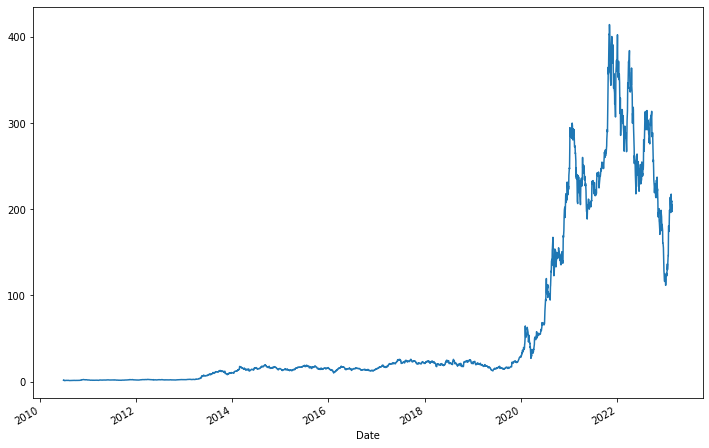

In [ ]:
my_data['High'].plot(figsize=(12,8))

In [ ]:
#xlimit and ylimit

In [ ]:
my_data['High'].plot(xlim=['2022-01-01','2022-09-01'],ylim=[0,400],figsize=(12,8))

<AxesSubplot:xlabel='Date'>

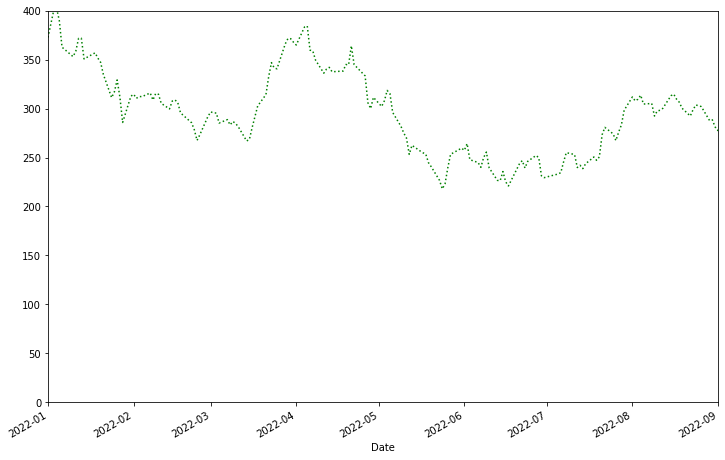

In [ ]:
my_data['High'].plot(xlim=['2022-01-01','2022-09-01'],ylim=[0,400],figsize=(12,8),ls='dotted',c='green')

### time resampling

**RULE A MEANS YEAR END FREQUENCY**

In [ ]:
#will give the min values of each column in particular year
#RULE A MEANS YEAR END FREQUENCY
my_data.resample(rule='A').min()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-12-31    1.076000    1.108667    0.998667    1.053333    1.053333   
2011-12-31    1.452000    1.484667    1.407333    1.455333    1.455333   
2012-12-31    1.774667    1.790000    1.509333    1.519333    1.519333   
2013-12-31    2.205333    2.225333    2.140667    2.194000    2.194000   
2014-12-31    9.366667    9.800000    9.111333    9.289333    9.289333   
2015-12-31   12.388667   12.619333   12.093333   12.333333   12.333333   
2016-12-31    9.488000   10.331333    9.403333    9.578000    9.578000   
2017-12-31   14.316667   14.688667   14.064000   14.466000   14.466000   
2018-12-31   16.851999   17.355333   16.306000   16.704000   16.704000   
2019-12-31   12.073333   12.445333   11.799333   11.931333   11.931333   
2020-12-31   24.980000   26.990667   23.367332   24.081333   24.081333   
2021-12-31  184.183334  188.736664  179.830002  187.666672  187.666672   
2022-12-31  110.349998  116.269997  108.239998  109.099998  109.099998   
2023-12-31  103.000000  111.750000  101.809998  108.099998  108.099998   

               Volume  
Date                   
2010-12-31    1777500  
2011-12-31    3594000  
2012-12-31    5473500  
2013-12-31    6603000  
2014-12-31   19983000  
2015-12-31   10620000  
2016-12-31   24892500  
2017-12-31   32800500  
2018-12-31   46210500  
2019-12-31   36984000  
2020-12-31   52073100  
2021-12-31   29401800  
2022-12-31   41864700  
2023-12-31  138429900

<AxesSubplot:xlabel='Date'>

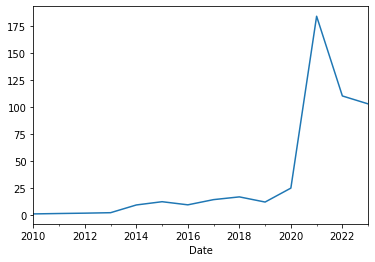

In [ ]:
my_data.resample(rule='A')['Open'].min().plot()

In [ ]:
my_data.resample(rule='A')['Open'].max()

Date
2010-12-31      2.391333
2011-12-31      2.308667
2012-12-31      2.546000
2013-12-31     12.930667
2014-12-31     19.177999
2015-12-31     18.680000
2016-12-31     17.763332
2017-12-31     25.779333
2018-12-31     25.000000
2019-12-31     29.000000
2020-12-31    233.330002
2021-12-31    411.470001
2022-12-31    396.516663
2023-12-31    211.759995
Freq: A-DEC, Name: Open, dtype: float64

<AxesSubplot:xlabel='Date'>

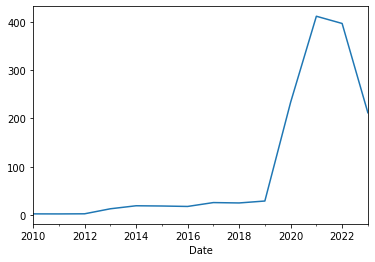

In [ ]:
my_data.resample(rule='A')['Open'].max().plot()

In [ ]:
my_data.resample(rule='A')['High'].max()

Date
2010-12-31      2.428000
2011-12-31      2.333333
2012-12-31      2.663333
2013-12-31     12.966667
2014-12-31     19.427999
2015-12-31     19.110001
2016-12-31     17.955999
2017-12-31     25.974001
2018-12-31     25.830667
2019-12-31     29.020666
2020-12-31    239.573334
2021-12-31    414.496674
2022-12-31    402.666656
2023-12-31    217.649994
Freq: A-DEC, Name: High, dtype: float64

<AxesSubplot:xlabel='Date'>

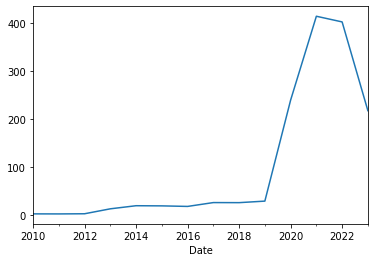

In [ ]:
my_data.resample(rule='A')['High'].max().plot()

**QUARTERLY FREQUENCY**

In [ ]:
my_data.resample(rule='QS').min()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-04-01    1.266667    1.666667    1.169333    1.588667    1.588667   
2010-07-01    1.076000    1.108667    0.998667    1.053333    1.053333   
2010-10-01    1.344000    1.352000    1.333333    1.336667    1.336667   
2011-01-01    1.452000    1.484667    1.407333    1.455333    1.455333   
2011-04-01    1.658000    1.680667    1.613333    1.643333    1.643333   
2011-07-01    1.462000    1.540667    1.433333    1.463333    1.463333   
2011-10-01    1.552667    1.621333    1.528667    1.577333    1.577333   
2012-01-01    1.774667    1.792000    1.509333    1.519333    1.519333   
2012-04-01    1.838667    1.892667    1.788667    1.837333    1.837333   
2012-07-01    1.789333    1.790000    1.701333    1.740000    1.740000   
2012-10-01    1.825333    1.853333    1.790667    1.822000    1.822000   
2013-01-01    2.205333    2.225333    2.140667    2.194000    2.194000   
2013-04-01    2.713333    2.788667    2.680667    2.700000    2.700000   
2013-07-01    7.101333    7.851333    6.966667    7.270000    7.270000   
2013-10-01    7.958667    8.181333    7.740000    8.033333    8.033333   
2014-01-01    9.366667    9.800000    9.111333    9.289333    9.289333   
2014-04-01   11.990667   12.226667   11.814667   11.906000   11.906000   
2014-07-01   14.396667   14.703333   14.240000   14.360000   14.360000   
2014-10-01   12.870667   13.578667   12.843333   13.187333   13.187333   
2015-01-01   12.388667   12.619333   12.093333   12.333333   12.333333   
2015-04-01   12.580000   12.820000   12.403333   12.506000   12.506000   
2015-07-01   13.519333   15.200000   13.000000   14.591333   14.591333   
2015-10-01   13.739333   14.108667   13.466667   13.795333   13.795333   
2016-01-01    9.488000   10.331333    9.403333    9.578000    9.578000   
2016-04-01   12.670000   13.008000   12.524667   12.876667   12.876667   
2016-07-01   13.000000   13.194667   12.896667   12.964667   12.964667   
2016-10-01   12.167333   12.315333   11.879333   12.096667   12.096667   
2017-01-01   14.316667   14.688667   14.064000   14.466000   14.466000   
2017-04-01   19.126667   19.933332   18.972000   19.666668   19.666668   
2017-07-01   20.860001   21.133333   20.208668   20.588667   20.588667   
2017-10-01   19.966667   20.297333   19.508667   19.950666   19.950666   
2018-01-01   17.099333   17.912001   16.547333   17.185333   17.185333   
2018-04-01   16.851999   17.355333   16.306000   16.832001   16.832001   
2018-07-01   17.340000   17.889999   16.816668   17.549334   17.549334   
2018-10-01   17.016666   17.457333   16.518000   16.704000   16.704000   
2019-01-01   17.313999   17.545334   16.964001   17.361334   17.361334   
2019-04-01   12.073333   12.445333   11.799333   11.931333   11.931333   
2019-07-01   14.240000   14.334667   14.066667   14.093333   14.093333   
2019-10-01   15.320000   15.632000   14.952000   15.428667   15.428667   
2020-01-01   24.980000   26.990667   23.367332   24.081333   24.081333   
2020-04-01   32.068668   32.950668   29.760000   30.298000   30.298000   
2020-07-01   72.199997   75.688667   72.033333   74.641998   74.641998   
2020-10-01  131.333328  135.660004  126.370003  129.346664  129.346664   
2021-01-01  200.183334  205.493332  179.830002  187.666672  187.666672   
2021-04-01  184.183334  188.736664  182.326660  187.820007  187.820007   
2021-07-01  209.456665  215.733337  206.820007  214.460007  214.460007   
2021-10-01  258.733337  260.260010  254.529999  258.406677  258.406677   
2022-01-01  233.463333  266.899994  233.333328  254.679993  254.679993   
2022-04-01  207.949997  217.973328  206.856674  209.386673  209.386673   
2022-07-01  223.000000  230.229996  216.166672  227.263336  227.263336   
2022-10-01  110.349998  116.269997  108.239998  109.099998  109.099998   
2023-01-01  103.000000  111.750000  101.809998  108.099998  108.099998   

               Volume

In [ ]:
my_data.resample(rule='QS').min()['High']

<AxesSubplot:xlabel='Date'>

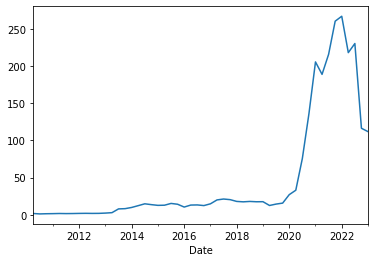

In [ ]:
my_data.resample(rule='QS').min()['High'].plot()

<AxesSubplot:xlabel='Date'>

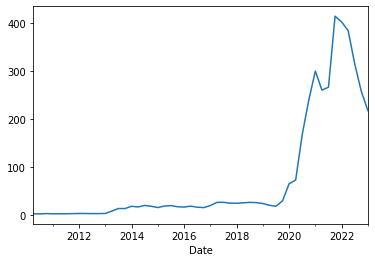

In [ ]:
my_data.resample(rule='QS').max()['High'].plot()

<AxesSubplot:xlabel='Date'>

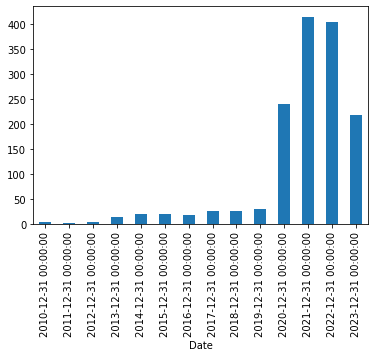

In [ ]:
my_data['High'].resample(rule='A').max().plot(kind='bar')

## **ROLLING**

In [ ]:
my_data['Open:30 days rolling']=my_data['Open'].rolling(30).mean()

In [ ]:
my_data.head()

Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500   
2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500   
2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000   
2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000   
2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500   

            Open:30 days rolling  
Date                              
2010-06-29                   NaN  
2010-06-30                   NaN  
2010-07-01                   NaN  
2010-07-02                   NaN  
2010-07-06                   NaN

<AxesSubplot:xlabel='Date'>

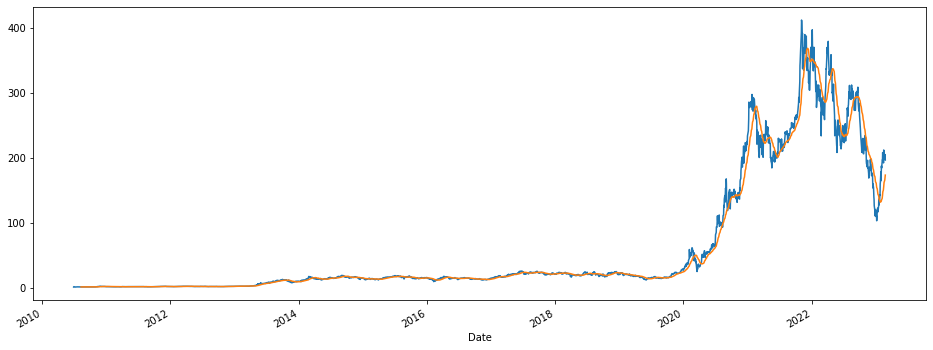

In [ ]:
my_data['Open'].plot(figsize=(16,6))
my_data['Open:30 days rolling'].plot(figsize=(16,6))

## **Smoothening Curve using Simple Average Method.**

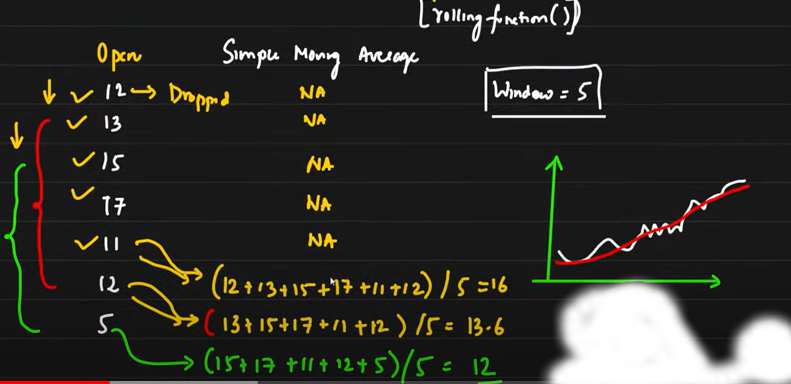

In [ ]:
my_data['Open:10 days rolling']=my_data['Open'].rolling(window=10,min_periods=1).mean()
my_data.head()

Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500   
2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500   
2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000   
2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000   
2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500   

            Open:30 days rolling  Open:10 days rolling  
Date                                                    
2010-06-29                   NaN              1.266667  
2010-06-30                   NaN              1.493000  
2010-07-01                   NaN              1.550889  
2010-07-02                   NaN              1.546500  
2010-07-06                   NaN              1.503867

<AxesSubplot:xlabel='Date'>

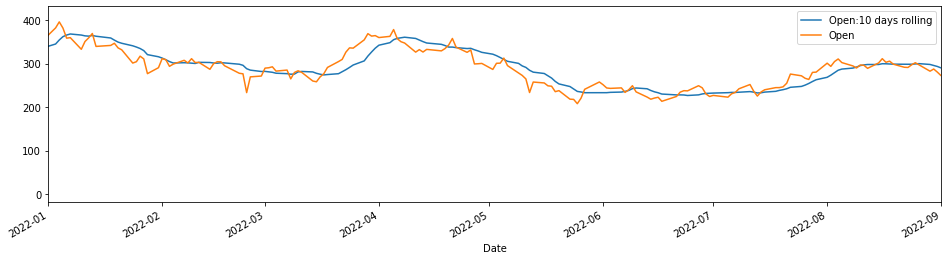

In [ ]:
my_data[['Open:10 days rolling','Open']].plot(xlim=['2022-01-01','2022-09-01'],figsize=(16,4))


In [ ]:
my_data['Open:40 days rolling']=my_data['Open'].rolling(window=40,min_periods=1).mean()
my_data

Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-06-29    1.266667    1.666667    1.169333    1.592667    1.592667   
2010-06-30    1.719333    2.028000    1.553333    1.588667    1.588667   
2010-07-01    1.666667    1.728000    1.351333    1.464000    1.464000   
2010-07-02    1.533333    1.540000    1.247333    1.280000    1.280000   
2010-07-06    1.333333    1.333333    1.055333    1.074000    1.074000   
...                ...         ...         ...         ...         ...   
2023-02-17  199.990005  208.440002  197.500000  208.309998  208.309998   
2023-02-21  204.990005  209.710007  197.220001  197.369995  197.369995   
2023-02-22  197.929993  201.990005  191.779999  200.860001  200.860001   
2023-02-23  203.910004  205.139999  196.330002  202.070007  202.070007   
2023-02-24  196.330002  197.669998  192.800003  196.880005  196.880005   

               Volume  Open:30 days rolling  Open:10 days rolling  \
Date                                                                
2010-06-29  281494500                   NaN              1.266667   
2010-06-30  257806500                   NaN              1.493000   
2010-07-01  123282000                   NaN              1.550889   
2010-07-02   77097000                   NaN              1.546500   
2010-07-06  103003500                   NaN              1.503867   
...               ...                   ...                   ...   
2023-02-17  213080200            161.927999            200.443999   
2023-02-21  180018600            165.327666            201.642000   
2023-02-22  191828500            167.959999            201.792000   
2023-02-23  146360000            170.721333            202.573000   
2023-02-24  141965900            173.195999            201.428000   

            Open:40 days rolling  
Date                              
2010-06-29              1.266667  
2010-06-30              1.493000  
2010-07-01              1.550889  
2010-07-02              1.546500  
2010-07-06              1.503867  
...                          ...  
2023-02-17            151.645749  
2023-02-21            153.287000  
2023-02-22            154.835249  
2023-02-23            156.773749  
2023-02-24            158.744499  

[3187 rows x 9 columns]

<AxesSubplot:xlabel='Date'>

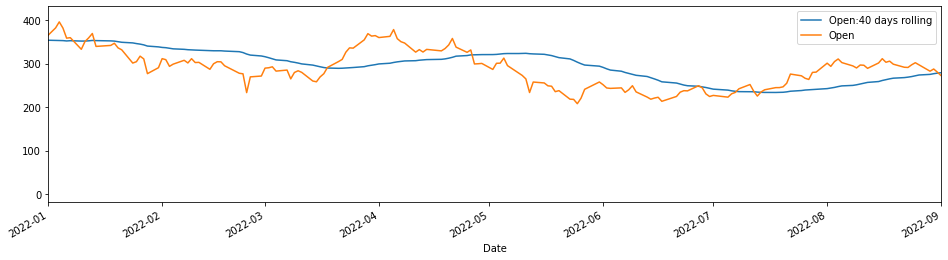

In [ ]:
my_data[['Open:40 days rolling','Open']].plot(xlim=['2022-01-01','2022-09-01'],figsize=(16,4))

In [ ]:
my_data['Open:20 days rolling']=my_data['Open'].rolling(window=20,min_periods=1).mean()
my_data

Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-06-29    1.266667    1.666667    1.169333    1.592667    1.592667   
2010-06-30    1.719333    2.028000    1.553333    1.588667    1.588667   
2010-07-01    1.666667    1.728000    1.351333    1.464000    1.464000   
2010-07-02    1.533333    1.540000    1.247333    1.280000    1.280000   
2010-07-06    1.333333    1.333333    1.055333    1.074000    1.074000   
...                ...         ...         ...         ...         ...   
2023-02-17  199.990005  208.440002  197.500000  208.309998  208.309998   
2023-02-21  204.990005  209.710007  197.220001  197.369995  197.369995   
2023-02-22  197.929993  201.990005  191.779999  200.860001  200.860001   
2023-02-23  203.910004  205.139999  196.330002  202.070007  202.070007   
2023-02-24  196.330002  197.669998  192.800003  196.880005  196.880005   

               Volume  Open:30 days rolling  Open:10 days rolling  \
Date                                                                
2010-06-29  281494500                   NaN              1.266667   
2010-06-30  257806500                   NaN              1.493000   
2010-07-01  123282000                   NaN              1.550889   
2010-07-02   77097000                   NaN              1.546500   
2010-07-06  103003500                   NaN              1.503867   
...               ...                   ...                   ...   
2023-02-17  213080200            161.927999            200.443999   
2023-02-21  180018600            165.327666            201.642000   
2023-02-22  191828500            167.959999            201.792000   
2023-02-23  146360000            170.721333            202.573000   
2023-02-24  141965900            173.195999            201.428000   

            Open:40 days rolling  Open:20 days rolling  
Date                                                    
2010-06-29              1.266667              1.266667  
2010-06-30              1.493000              1.493000  
2010-07-01              1.550889              1.550889  
2010-07-02              1.546500              1.546500  
2010-07-06              1.503867              1.503867  
...                          ...                   ...  
2023-02-17            151.645749            181.770499  
2023-02-21            153.287000            185.226500  
2023-02-22            154.835249            187.973000  
2023-02-23            156.773749            191.073000  
2023-02-24            158.744499            192.891000  

[3187 rows x 10 columns]

<AxesSubplot:xlabel='Date'>

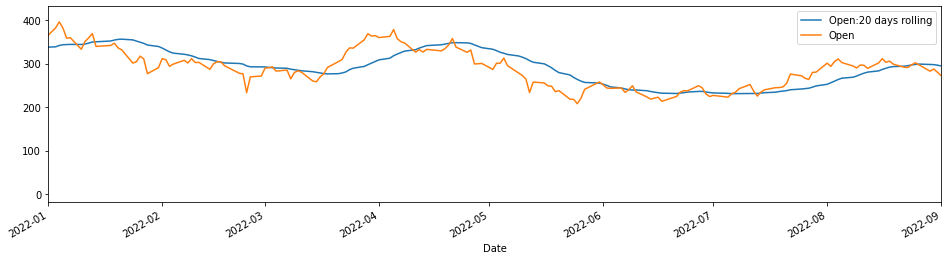

In [ ]:
my_data[['Open:20 days rolling','Open']].plot(xlim=['2022-01-01','2022-09-01'],figsize=(16,4))

<AxesSubplot:xlabel='Date'>

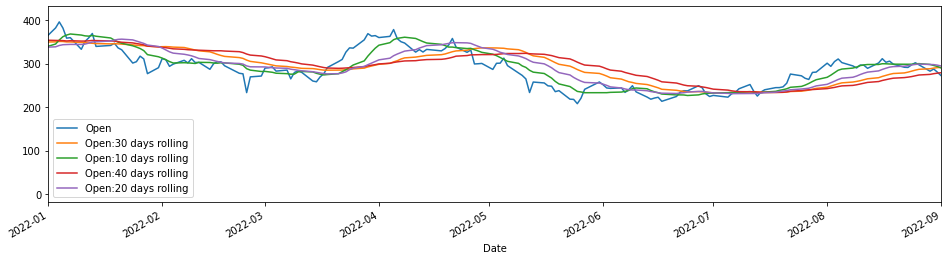

In [ ]:
my_data[['Open','Open:30 days rolling','Open:10 days rolling','Open:40 days rolling','Open:20 days rolling']].plot(xlim=['2022-01-01','2022-09-01'],figsize=(16,4))

**Disadvantage of simple moving average**

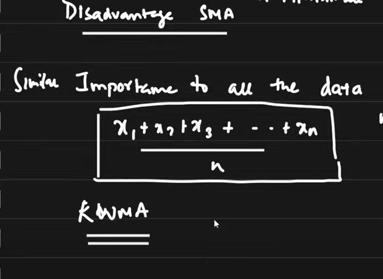

## **## Cummalative moving Average**

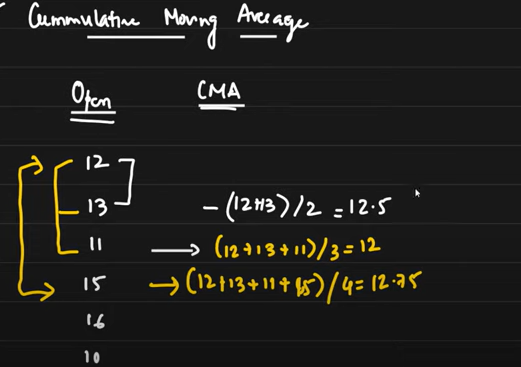

In [ ]:
my_data['Open'].expanding().mean()

Date
2010-06-29     1.266667
2010-06-30     1.493000
2010-07-01     1.550889
2010-07-02     1.546500
2010-07-06     1.503867
                ...    
2023-02-17    59.882736
2023-02-21    59.928309
2023-02-22    59.971638
2023-02-23    60.016816
2023-02-24    60.059588
Name: Open, Length: 3187, dtype: float64

<AxesSubplot:xlabel='Date'>

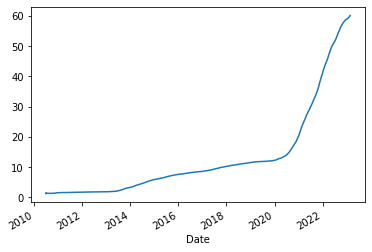

In [ ]:
my_data['Open'].expanding().mean().plot()

## **## Exponential Moving Average**

In [ ]:
my_data['EMA_0.1']=my_data['Open'].ewm(alpha=0.1,adjust=False).mean()

In [ ]:
my_data.head()

Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500   
2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500   
2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000   
2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000   
2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500   

            Open:30 days rolling  Open:10 days rolling  Open:40 days rolling  \
Date                                                                           
2010-06-29                   NaN              1.266667              1.266667   
2010-06-30                   NaN              1.493000              1.493000   
2010-07-01                   NaN              1.550889              1.550889   
2010-07-02                   NaN              1.546500              1.546500   
2010-07-06                   NaN              1.503867              1.503867   

            Open:20 days rolling   EMA_0.1  
Date                                        
2010-06-29              1.266667  1.266667  
2010-06-30              1.493000  1.311934  
2010-07-01              1.550889  1.347407  
2010-07-02              1.546500  1.366000  
2010-07-06              1.503867  1.362733

<AxesSubplot:xlabel='Date'>

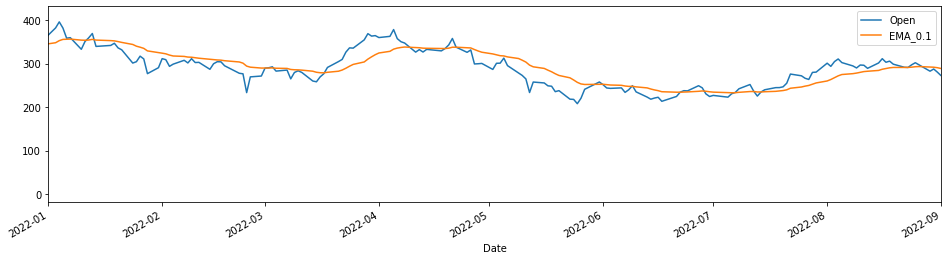

In [ ]:
my_data[['Open','EMA_0.1']].plot(xlim=['2022-01-01','2022-09-01'],figsize=(16,4))

In [ ]:
my_data['EMA_0.3']=my_data['Open'].ewm(alpha=0.3,adjust=False).mean()

<AxesSubplot:xlabel='Date'>

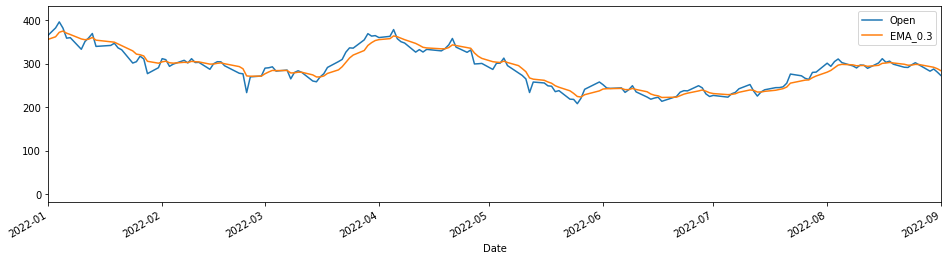

In [ ]:
my_data[['Open','EMA_0.3']].plot(xlim=['2022-01-01','2022-09-01'],figsize=(16,4))

##** ARIMA SARIMAX**

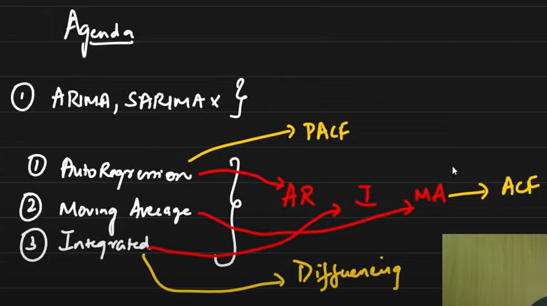

## **Time Series Notes**

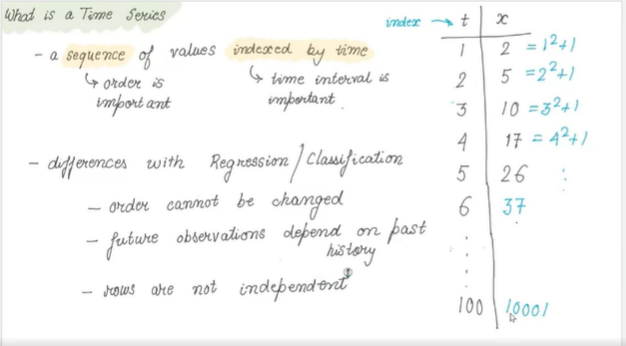

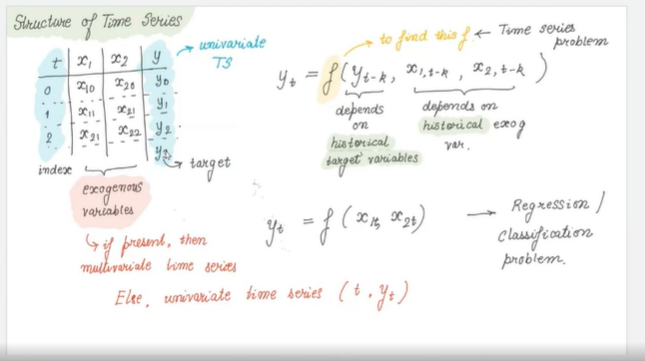

## **MOVING AVERAGE**

**Move, smoothe, evaluate**


Let's start with a naive hypothesis: "tomorrow will be the same as today". However, instead of a model like 
 (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), we will assume that the future value of our variable depends on the average of its 
 previous values. Therefore, we will use the **moving average.**
 


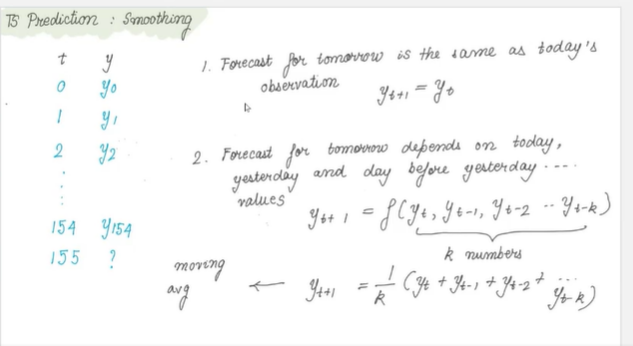

In [ ]:
import numpy as np

In [ ]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(my_data['Open'], 24) # prediction for next day, using the last observed day's data.  (past 24 days)

184.94041633605957

In [ ]:
my_data['Open'].tail()

Date
2023-02-17    199.990005
2023-02-21    204.990005
2023-02-22    197.929993
2023-02-23    203.910004
2023-02-24    196.330002
Name: Open, dtype: float64

Unfortunately, we cannot make predictions far in the future -- in order to get the value for the next step, we need the previous values to be actually observed. But moving average has another use case - smoothing the original time series to identify trends. Pandas has an implementation available with **DataFrame.rolling(window).mean()**. The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.This smoothening has been done in the begining part of the colab.

## **WEIGHTED MOVING AVERAGE**

**Weighted average** is a simple modification to the moving average. The weights sum up to 1 with larger weights assigned to more recent observations.


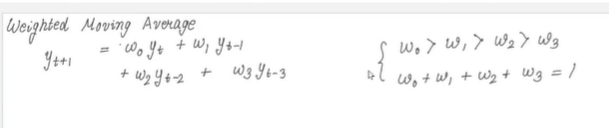

In [ ]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)
weighted_average(my_data['Open'], [0.6, 0.3, 0.1])

198.76400146484374

In [ ]:
my_data['Open'].tail()

Date
2023-02-17    199.990005
2023-02-21    204.990005
2023-02-22    197.929993
2023-02-23    203.910004
2023-02-24    196.330002
Name: Open, dtype: float64

## **EXPONENTIAL SMOOTHENING**

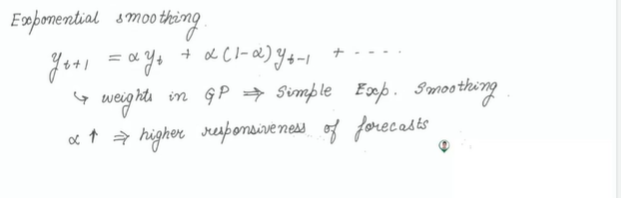

**Exponential smoothing**

Now, let's see what happens if, instead of weighting the last 
 values of the time series, we start weighting all available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for exponential smoothing that will help us with this:
Here the model value is a weighted average between the current true value and the previous model values. The alpha
 weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller the alpha
 is, the more influence the previous observations have and the smoother the series is.
Exponentiality is hidden in the recursiveness of the function -- we multiply by 
 (1-alpha) each time, which already contains a multiplication by 
 of previous model values.

In [ ]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [ ]:
exponential_smoothing(my_data['Open'],0.5)

## **DOUBLE EXPONENTIAL SMOOTHENING**

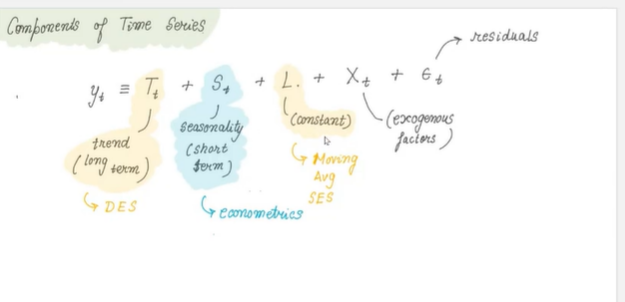

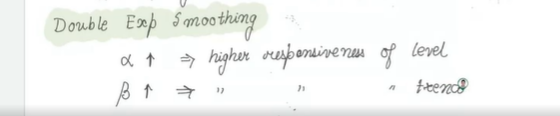

Holt (1957) extended simple exponential smoothing to allow the forecasting of data with a trend. This method involves a forecast equation and two smoothing equations (one(**Alpha**) for the level and one(**Beta**) for the trend):